In [23]:
import scipy

In [52]:
def gen_density_map_gaussian(im, points, sigma=4):
    """
    func: generate the density map
    """
    density_map = np.zeros(im.shape[:2], dtype=np.float32)
    h, w = density_map.shape[:2]
    num_gt = np.squeeze(points).shape[0]
    if num_gt == 0:
        return density_map
    if sigma == 4:
        # Adaptive sigma in CSRNet.
        leafsize = 2048
        tree = scipy.spatial.KDTree(points.copy(), leafsize=leafsize)
        distances, _ = tree.query(points, k=4)
    for idx_p, p in enumerate(points):
        p = np.round(p).astype(int)
        p[0], p[1] = min(h-1, p[1]), min(w-1, p[0])
        gaussian_radius = sigma * 2 - 1
        if sigma == 4:
            # Adaptive sigma in CSRNet.
            sigma = max(int(np.sum(distances[idx_p][1:4]) * 0.1), 1)
            gaussian_radius = sigma * 3
        gaussian_map = np.multiply(
            cv2.getGaussianKernel(int(gaussian_radius*2+1), sigma),
            cv2.getGaussianKernel(int(gaussian_radius*2+1), sigma).T
        )
        x_left, x_right, y_up, y_down = 0, gaussian_map.shape[1], 0, gaussian_map.shape[0]
        # cut the gaussian kernel
        if p[1] < gaussian_radius:
            x_left = gaussian_radius - p[1]
        if p[0] < gaussian_radius:
            y_up = gaussian_radius - p[0]
        if p[1] + gaussian_radius >= w:
            x_right = gaussian_map.shape[1] - (gaussian_radius + p[1] - w) - 1
        if p[0] + gaussian_radius >= h:
            y_down = gaussian_map.shape[0] - (gaussian_radius + p[0] - h) - 1
        gaussian_map = gaussian_map[y_up:y_down, x_left:x_right]
        if np.sum(gaussian_map):
            gaussian_map = gaussian_map / np.sum(gaussian_map)
        print(p)
        density_map[
            max(0, p[0]-gaussian_radius):min(h, p[0]+gaussian_radius+1),
            max(0, p[1]-gaussian_radius):min(w, p[1]+gaussian_radius+1)
        ] += gaussian_map
    density_map = density_map / (np.sum(density_map / num_gt))
    return density_map

In [5]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import json
from os import path

In [9]:
ann = pd.read_csv("/mnt/d/personal/cotton/samples/via_export_csv.csv")

In [4]:
base_path = "/mnt/d/personal/cotton/samples/"

In [310]:
create_images = True
data = []
pos_cnt = 1
neg_cnt = 1
all_data = pd.DataFrame()
X = []
Y = []
for file in ann["filename"].unique():
    print(file)
    sample_ann = ann[ann["filename"] == file]
    # file_name = "2019_1010_123336_234.JPG"
    # sample_ann = ann[ann["filename"]==file_name]
    img = cv2.imread(path.join(base_path, file_name))
    points = np.zeros((img.shape[0], img.shape[1]))

    # Read all the annotations
    for ix, val in sample_ann.iterrows():
        coords = json.loads(val["region_shape_attributes"])
        center = [int(coords["y"] + (coords["height"] / 2)), int(coords["x"] + (coords["width"] / 2))]
        sample_ann.loc[ix, "centery"] = center[0]
        sample_ann.loc[ix, "centerx"] = center[1]
        points[center[0]][center[1]] = 1
    imgs = []
    pts = []
    for _x in range(100):
        for _y in range(100):
            xstart = _x * 30
            xend = (_x + 1) * 30
            ystart = _y * 40
            yend = (_y + 1) * 40
            # X.append(img[xstart:xend, ystart:yend])
            points_sc = points[xstart:xend, ystart:yend]
            pts = []
            for ii, jj in zip(np.nonzero(points_sc)[1], np.nonzero(points_sc)[0]):
                pts.append([ii, jj])
            if len(pts) > 0:
                X.append(img[xstart:xend, ystart:yend] * 1/255.0)
                Y.append(gen_density_map_gaussian(X[-1], pts, 3))    

2019_1010_123336_234.JPG


/home/suba/.virtualenvs/cotton/lib/python3.6/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/suba/.virtualenvs/cotton/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


2019_1010_123338_235.JPG
2019_1010_123339_236.JPG
2019_1010_123341_237.JPG
2019_1010_123342_238.JPG
2019_1010_123344_239.JPG
2019_1010_123345_240.JPG
2019_1010_123347_241.JPG
2019_1010_123348_242.JPG
2019_1010_123350_243.JPG
2019_1010_123351_244.JPG
2019_1010_123353_245.JPG


KeyError: 'y'

In [311]:
print(len(X), len(Y))

804 804


In [243]:
X.shape

AttributeError: 'list' object has no attribute 'shape'

In [211]:
np.nonzero(points)

(array([], dtype=int64), array([], dtype=int64))

In [31]:
img_sm = img[2500:2700, 3600:3800]

In [32]:
points_sm = points[2500:2700, 3600:3800]

In [111]:
def gen_density_map_gaussian(im, points, sigma=4):
    """
    func: generate the density map
    """
    density_map = np.zeros(im.shape[:2], dtype=np.float32)
    h, w = density_map.shape[:2]
    num_gt = np.squeeze(points).shape[0]
    if num_gt == 0:
        return density_map
    if sigma == 4:
        # Adaptive sigma in CSRNet.
        leafsize = 2048
        tree = scipy.spatial.KDTree(points.copy(), leafsize=leafsize)
        distances, _ = tree.query(points, k=4)
    for idx_p, p in enumerate(points):
        p = np.round(p).astype(int)
        p[0], p[1] = min(h-1, p[1]), min(w-1, p[0])
        gaussian_radius = sigma * 2 - 1
        if sigma == 4:
            # Adaptive sigma in CSRNet.
            sigma = max(int(np.sum(distances[idx_p][1:4]) * 0.1), 1)
            gaussian_radius = sigma * 3
        gaussian_map = np.multiply(
            cv2.getGaussianKernel(int(gaussian_radius*2+1), sigma),
            cv2.getGaussianKernel(int(gaussian_radius*2+1), sigma).T
        )
        x_left, x_right, y_up, y_down = 0, gaussian_map.shape[1], 0, gaussian_map.shape[0]
        # cut the gaussian kernel
        if p[1] < gaussian_radius:
            x_left = gaussian_radius - p[1]
        if p[0] < gaussian_radius:
            y_up = gaussian_radius - p[0]
        if p[1] + gaussian_radius >= w:
            x_right = gaussian_map.shape[1] - (gaussian_radius + p[1] - w) - 1
        if p[0] + gaussian_radius >= h:
            y_down = gaussian_map.shape[0] - (gaussian_radius + p[0] - h) - 1
        gaussian_map = gaussian_map[y_up:y_down, x_left:x_right]
        if np.sum(gaussian_map):
            gaussian_map = gaussian_map / np.sum(gaussian_map)
        density_map[
            max(0, p[0]-gaussian_radius):min(h, p[0]+gaussian_radius+1),
            max(0, p[1]-gaussian_radius):min(w, p[1]+gaussian_radius+1)
        ] += gaussian_map
    density_map = density_map / (np.sum(density_map / num_gt))
    return density_map

In [64]:
img_gaus = gen_density_map_gaussian(img_sm, [[91, 61]], 5)

[61 91]


In [26]:
import scipy.spatial

In [256]:
for ix in range(50):
    cv2.imwrite(path.join(base_path, "regression", str(ix) + ".jpg"), X[ix])
    temp = X[ix].copy()
    temp[:, :, 2] =  temp[:, :, 2] + Y[ix]
    cv2.imwrite(path.join(base_path, "regression", str(ix) + "ann.jpg"), temp)

In [81]:
img_sm_cp = img_sm.copy()

In [82]:
img_sm_cp[:, :, 0] = img_sm_cp[:,:, 0] +img_gaus * 25555
# img_sm_cp[:, :, 1] = img_sm_cp[:,:, 1] +img_gaus * 25555
# img_sm_cp[:, :, 2] = img_sm_cp[:,:, 2] +img_gaus * 25555

In [83]:
cv2.imwrite(path.join(base_path, "zgauss.jpg"), img_sm_cp)

True

In [40]:
np.nonzero(img_gaus)

(array([ 0,  0,  0, ..., 39, 39, 39]), array([ 0,  1,  2, ..., 37, 38, 39]))

In [41]:
img_gaus

array([[0.33711848, 0.3366986 , 0.33543748, ..., 0.        , 0.        ,
        0.        ],
       [0.3366986 , 0.3362775 , 0.33501938, ..., 0.        , 0.        ,
        0.        ],
       [0.33543748, 0.33501938, 0.33376437, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [46]:
np.nonzero(points_sm)

(array([91]), array([61]))

In [51]:
np.squeeze(points_sm).shape[0]

200

In [55]:
points_sm[91]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [366]:
shutil.move?

In [84]:
img.shape

(3000, 4000, 3)

In [85]:
points.shape

(3000, 4000)

In [86]:
np.nonzero(points)

(array([2591]), array([3661]))

In [94]:
imgs = []
points_sc = []
for _x in range(10):
    for _y in range(10):
        xstart = _x * 300
        xend = (_x + 1) * 300
        ystart = _y * 400
        yend = (_y + 1) * 400
        imgs.append(img[xstart:xend, ystart:yend])
        points_sc.append(points[xstart:xend, ystart:yend])

In [105]:
pts = []
for i in points_sc:
    for ii, jj in zip(np.nonzero(i)[0], np.nonzero(i)[1]):
        pts.append([ii, jj])

In [150]:
from tensorflow.keras.layers import Dense, Conv2D, Input, MaxPooling2D, concatenate, add, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import RandomNormal

In [336]:
input_flow = Input(shape=(30, 40, 3))
dilated_conv_kernel_initializer = RandomNormal(stddev=0.01)

# front-end
x = Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu')(input_flow)
x = Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
x = Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
x = Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
# x = Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)

# x = Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
# x = Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
# x = Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)

# x = UpSampling2D((2,2))(x)
# x = Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
x = UpSampling2D((2,2))(x)
x = Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)

# # back-end
# x = Conv2D(512, (3, 3), strides=(1, 1), padding='same', dilation_rate=2, activation='relu', kernel_initializer=dilated_conv_kernel_initializer)(x)
# x = Conv2D(512, (3, 3), strides=(1, 1), padding='same', dilation_rate=2, activation='relu', kernel_initializer=dilated_conv_kernel_initializer)(x)
# x = Conv2D(512, (3, 3), strides=(1, 1), padding='same', dilation_rate=2, activation='relu', kernel_initializer=dilated_conv_kernel_initializer)(x)
# x = Conv2D(256, (3, 3), strides=(1, 1), padding='same', dilation_rate=2, activation='relu', kernel_initializer=dilated_conv_kernel_initializer)(x)
# x = Conv2D(128, (3, 3), strides=(1, 1), padding='same', dilation_rate=2, activation='relu', kernel_initializer=dilated_conv_kernel_initializer)(x)
# x = Conv2D(64, (3, 3), strides=(1, 1), padding='same', dilation_rate=2, activation='relu', kernel_initializer=dilated_conv_kernel_initializer)(x)

output_flow = Conv2D(1, 1, strides=(1, 1), padding='same', activation='relu', kernel_initializer=dilated_conv_kernel_initializer)(x)
model = Model(inputs=input_flow, outputs=output_flow)

In [338]:
model.summary()

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 30, 40, 3)]       0         
_________________________________________________________________
conv2d_150 (Conv2D)          (None, 30, 40, 64)        1792      
_________________________________________________________________
conv2d_151 (Conv2D)          (None, 30, 40, 64)        36928     
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 15, 20, 64)        0         
_________________________________________________________________
conv2d_152 (Conv2D)          (None, 15, 20, 128)       73856     
_________________________________________________________________
conv2d_153 (Conv2D)          (None, 15, 20, 128)       147584    
_________________________________________________________________
conv2d_154 (Conv2D)          (None, 15, 20, 256)       295

In [240]:
np.sum(YY[0])

30.183594

In [339]:
model.compile(optimizer="adam", loss='MSE', metrics=["mae", "mse"])

In [340]:
model.fit(X, Y, epochs=10, validation_split=0.2)

Train on 643 samples, validate on 161 samples
Epoch 1/10
643/643 [==============================] - 20s 30ms/sample - loss: 1.7293 - mae: 0.5014 - mse: 1.7293 - val_loss: 1.7233 - val_mae: 0.5718 - val_mse: 1.7233
Epoch 2/10
643/643 [==============================] - 19s 30ms/sample - loss: 1.6919 - mae: 0.5881 - mse: 1.6919 - val_loss: 1.7170 - val_mae: 0.5889 - val_mse: 1.7170
Epoch 3/10
643/643 [==============================] - 20s 31ms/sample - loss: 1.6884 - mae: 0.5999 - mse: 1.6884 - val_loss: 1.7150 - val_mae: 0.5994 - val_mse: 1.7150
Epoch 4/10
643/643 [==============================] - 20s 31ms/sample - loss: 1.6874 - mae: 0.6017 - mse: 1.6874 - val_loss: 1.7165 - val_mae: 0.6235 - val_mse: 1.7165
Epoch 5/10
643/643 [==============================] - 20s 31ms/sample - loss: 1.6865 - mae: 0.6044 - mse: 1.6865 - val_loss: 1.7165 - val_mae: 0.5955 - val_mse: 1.7165
Epoch 6/10
643/643 [==============================] - 21s 32ms/sample - loss: 1.6851 - mae: 0.6055 - mse: 1.6851 -

In [273]:
def show(img):
    plt.imshow(img[:, :, ::-1])

In [268]:
test_img = cv2.imread(path.join(base_path, "regression", "24.jpg"))

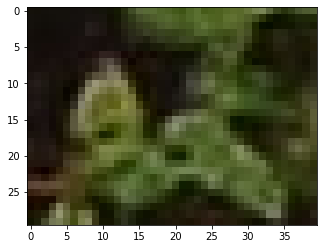

In [358]:
show(X[1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


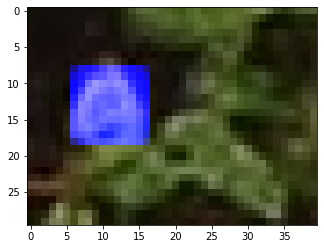

In [359]:
temp = X[1].copy()
temp[:, :, 0] = temp[:,:, 0] + Y[1]
show(temp)

In [349]:
pred = model.predict(np.array([test_img]) * 1 / 255.)

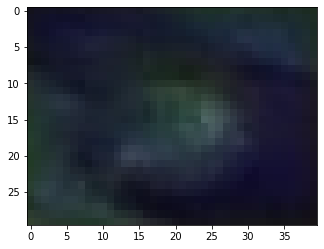

In [355]:
temp = test_img.copy()
temp[:, :, 0] = temp[:,:, 0] + pred[0][:, :, 0] * 100
show(temp)

In [357]:
np.sum(pred) / 200

2.0406428527832032

In [333]:
X = np.array(X)
Y = np.array(Y) * 200

In [246]:
for i in Y:
    print(np.sum(i))

1999.9999
2000.0
2000.0
2000.0
2000.0002
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
1999.9999
2000.0
1999.9999
2000.0
2000.0
2000.0001
2000.0
2000.0002
2000.0
2000.0
2000.0
2000.0001
2000.0
2000.0001
2000.0
2000.0001
2000.0
2000.0
2000.0
1999.9998
2000.0002
2000.0
2000.0
2000.0
2000.0
2000.0001
2000.0
2000.0001
2000.0001
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0001
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0001
2000.0
2000.0
2000.0
2000.0
2000.0001
2000.0
2000.0
2000.0
2000.0001
2000.0
2000.0
2000.0001
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0001
1999.9998
2000.0
2000.0
2000.0
2000.0
2000.0001
1999.9998
2000.0
2000.0
2000.0001
2000.0
2000.0
2000.0
2000.0
2000.0001
2000.0
2000.0
2000.0
2000.0001
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0001
2000.0001
2000.0001
2000.0002
2000.0002
2000.0
1999.9999
1999.9999
2000.0002
2000.0
2000.0
2000.0002
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0001
2000.0
2000.0
200

In [224]:
YY = []
for i in Y:
    YY.append(cv2.resize(i, (50, 37)) * 1000)
YY = np.array(YY)

In [225]:
for ix in range(len(YY)):
    rez = cv2.resize(YY[ix], (400, 300))
    print(np.sum(rez), np.sum(Y[ix]))

1957.5862 2.0
3885.1108 4.0
2966.4258 3.0000002
2042.5576 2.0
2070.1453 2.0
2088.4058 2.0
4033.766 4.0
5075.481 5.0
2063.2598 2.0
1919.2952 2.0
2066.2856 2.0
2732.1338 3.0
5081.0376 4.9999995
2082.2898 2.0
2133.7048 2.0
6858.475 7.000001
1939.9275 2.0
2023.5555 2.0
2091.1428 2.0
2088.8027 2.0
2057.3955 2.0
2091.702 2.0
2065.7512 2.0
6225.318 6.0
1986.8865 2.0
4125.5034 4.0
2157.9783 2.0000002
3067.9995 3.0
4018.5437 4.0
1930.8595 2.0
2075.8389 2.0
1828.7651 2.0
1947.6935 2.0
2017.5442 2.0000002
2085.7634 2.0
11073.673 11.0
2064.3914 2.0
1965.2642 2.0000002
1947.4069 2.0
1848.6885 2.0000002
3016.612 3.0
1952.1895 2.0
1969.1041 2.0
9071.793 9.0
2038.098 2.0
2103.1643 2.0
2075.2375 2.0
2053.1255 2.0
5830.7896 5.9999995
4958.625 5.0
2149.3667 2.0
2008.615 2.0
3110.1724 3.0
2943.8125 3.0
2983.1343 3.0
1915.0321 2.0000002
1849.3538 2.0
4126.6597 4.0000005
2088.318 2.0
1926.629 2.0
2998.199 2.9999998
2082.8523 2.0
2054.7273 2.0
2040.5591 2.0
2120.995 2.0000002
2066.003 2.0
3866.8367 4.0
3960.

In [363]:
np.where(temp==-1)[0].length

AttributeError: 'numpy.ndarray' object has no attribute 'length'